In [1]:
import sys; sys.path.append('./notebooks/')
from _load_llm_results import *
import numpy as np
import warnings
import os
import sys; sys.path.append('../')
from evaluate_model import read_data
import json

warnings.filterwarnings("ignore")

%matplotlib inline

from tqdm import tqdm
from glob import glob


In [2]:
def load_results(constraints=dict(scale=[False])):
    count = 0
    for file in tqdm(glob(f"{results_path}/**/*.json", recursive=True)):
        # print(file)

        try:
            cp_df = pd.read_json(file, typ="series")
        except Exception as e:
            # print("Bad results in file", file)
            continue
        
        # unifying column name
        cp_df = cp_df.rename(index={"few_feature": "icd_only"})

        # stay = True
        # for kc, vc in constraints.items():
        #     if df[kc] not in vc:
        #         stay = False
        #         print("skipping", file)
        #         break
        # if not stay:
        #     print('continuing')
        #     continue

        indxs = cp_df.index
        # indxs = [indx for indx in indxs if indx not in ['pred', 'pred_proba']]

        results.append(cp_df[indxs])
        count += 1

    print('loaded',count,'files')
    results_df = pd.DataFrame(data=results, columns=indxs)

    # Beautifying it
    results_df["model"] = results_df["model"].apply(lambda m: nice_model_labels[m])
    results_df["target"] = results_df["target"].apply(lambda t: dnames_to_nice[t])

    results_df = results_df[results_df["model"].isin(order)]

    print(results_df["model"].unique())
    print(results_df["target"].unique())
    return results_df
    
boxplot_kwargs = {
    'sharey':True,
    'notch': False,
    'showcaps':True,
    'flierprops':{"marker": "x"},
    # 'boxprops':{"facecolor": 'white'},
    'medianprops':{"color": "k", "linewidth": 1, 'alpha':0.5}
}

palette = sns.color_palette("hls", 6) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']

phenotypes_order =  ['HTN Heuristic', 'Htn-Hypokalemia Heuristic', 'Resistant HTN Heuristic',
                     'HTN Diagnosis', 'HTN-Hypokalemia Diagnosis', 'Resistant HTN Diagnosis']

settings_order = ['Simple prompt,\nfew features', 'Simple prompt,\nall features', 
                  'Rich prompt,\nfew features',   'Rich prompt,\nall features']

model_order = [
    'gpt-3.5-turbo',
    'gpt-3.5-turbo-iter',
    'gpt-4o-mini',
    'gpt-4o-mini-iter',
    'gpt-4o',
    'gpt-4o-iter',
    'gpt-4-turbo',
    'gpt-4-turbo-iter',
]

results_df = load_results()
# display(results_df)

# Making it the format seaborn likes
results_df_melted = pd.melt(
    results_df, 
    id_vars=['model', 'target', 'fold', 'RunID', 'random_state', 'prompt_richness', 'icd_only']
)

print(results_df.columns)
print(results_df.shape)

100%|██████████| 7200/7200 [00:55<00:00, 130.28it/s]


loaded 7200 files
['gpt-3.5-turbo' 'gpt-3.5-turbo-iter' 'gpt-4o' 'gpt-4o-iter' 'gpt-4o-mini'
 'gpt-4o-mini-iter']
['HTN Heuristic' 'HTN Diagnosis' 'HTN-Hypokalemia Diagnosis'
 'Htn-Hypokalemia Heuristic' 'Resistant HTN Heuristic'
 'Resistant HTN Diagnosis']
Index(['accuracy_score_train', 'precision_score_train',
       'average_precision_score_train', 'roc_auc_score_train',
       'balanced_accuracy_score_train', 'accuracy_score_test',
       'precision_score_test', 'average_precision_score_test',
       'roc_auc_score_test', 'balanced_accuracy_score_test', 'messages',
       'model', 'target', 'fold', 'RunID', 'random_state', 'representation',
       'representation_fmt', 'size', 'complexity', 'scale', 'icd_only',
       'prompt_richness', 'time', 'pred', 'pred_proba'],
      dtype='object')
(7200, 26)


In [3]:
# Number of results

# group by different experimental settings, count the occurence of experiments (any of
# 'fold', 'RunID', 'random_state' should do it), then pivot to fit everything in the screen

(
    results_df
    .groupby(['model', 'target', 'scale','prompt_richness', 'icd_only','fold']) 
    ['random_state']
    .nunique()
    .reset_index()
    .pivot_table(
        index=['target'], columns=['model', 'scale','prompt_richness', 'icd_only','fold'],
        values='random_state'
    )
    .T 
    .fillna(0).astype('int').style.background_gradient(axis=None, cmap='viridis')  \
)
    

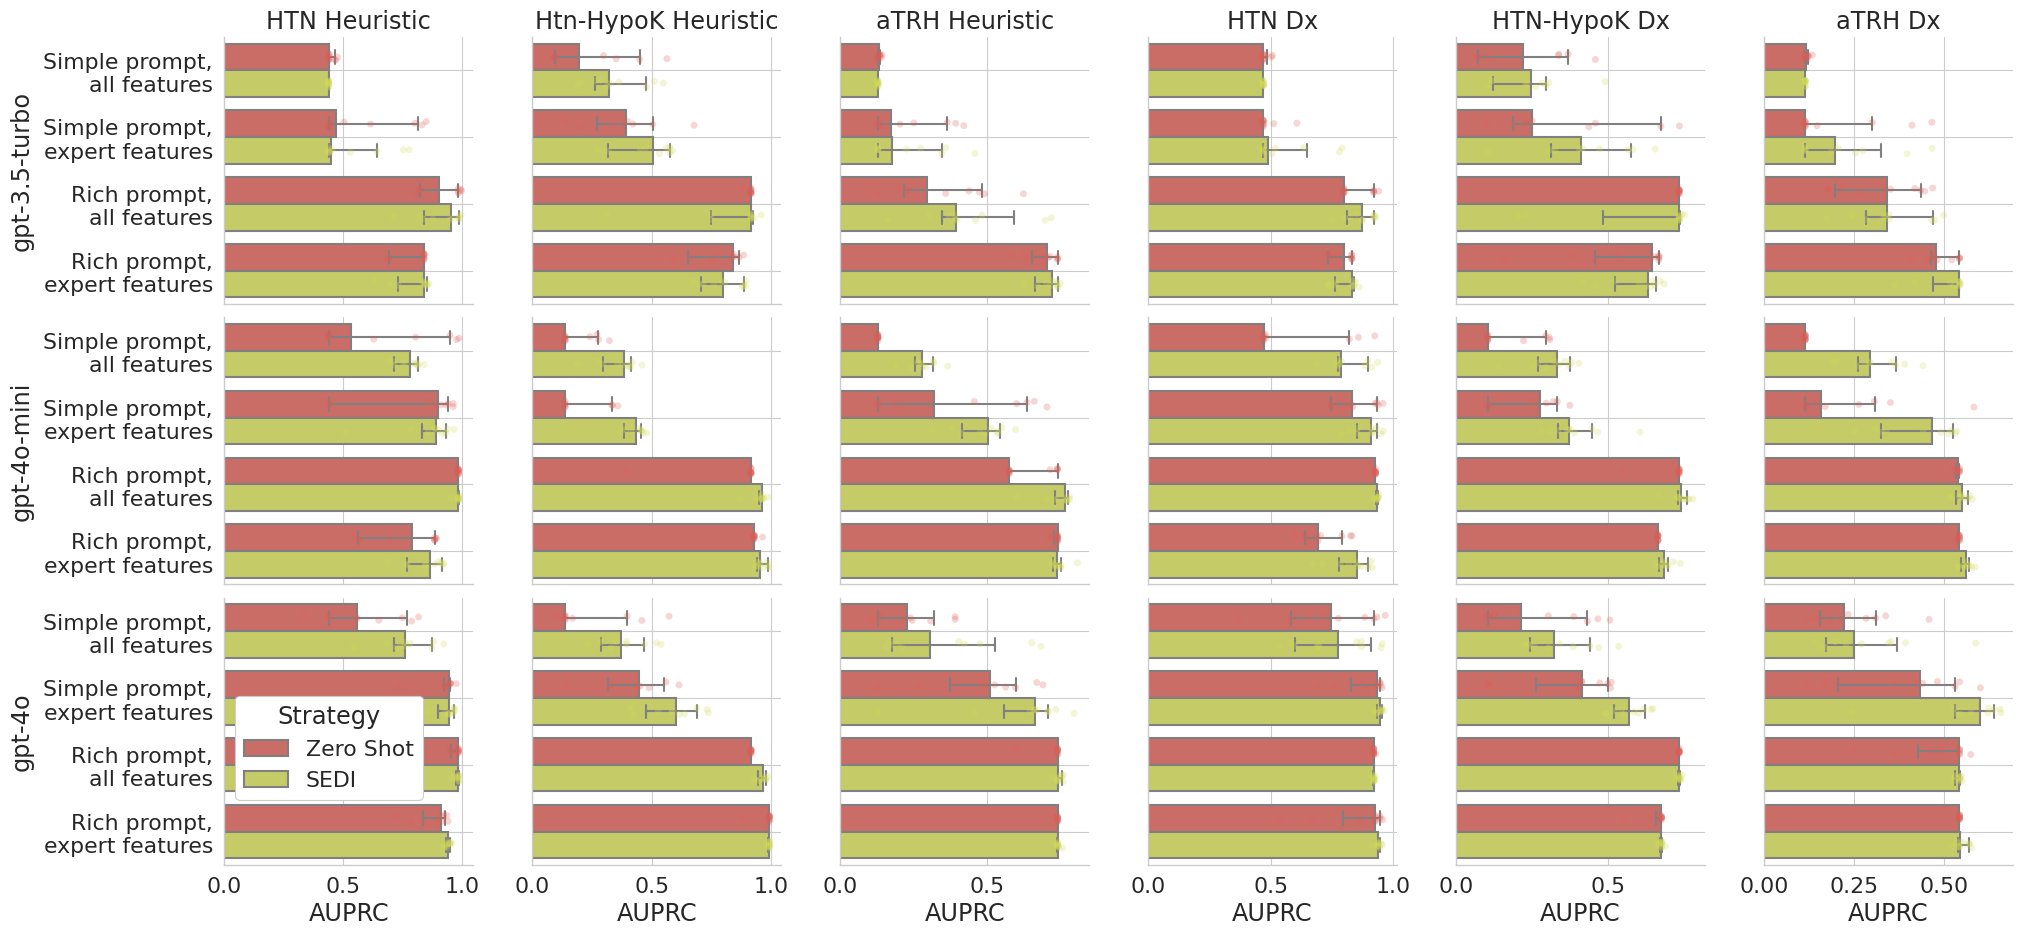

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.8
)
# sns.set_style('whitegrid')
# for target in results_df.target.unique():
for metric in [
    # 'accuracy_score_train',
    # 'accuracy_score_test',
    # 'average_precision_score_train',
    'average_precision_score_test',
    # 'roc_auc_score_train',
    # 'roc_auc_score_test',
    # 'size'
]: 
    data = results_df_melted[
        (results_df_melted['variable']==metric)
        # &
        # (results_df_melted['target']==target)
    ].copy()

    # grouping by iteration and calculating the average across folds
    # display(data)
    data = data.groupby([c for c in data.columns if c not in ['fold', 'value']])['value'].mean().reset_index()
    # display(data)

    data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]
    hue_order=['Zero Shot','SEDI']
    
    # data = data[~data['model'].str.contains("iterative")]
    
    metric = metric.replace('average_precision_score_test', 'AUPRC')

    data = data.rename(columns={'value': metric}) #, 'model':'Model'})
    data['Model'] = data['model'].apply(lambda x: x.replace('-iter',''))

    data['Setting'] = data[['icd_only', 'prompt_richness']].apply(
        lambda row: 
        f"{'Rich prompt,\n'  if row.prompt_richness  else 'Simple prompt,\n'}"
        f"{'expert features' if row.icd_only else 'all features'}", 
    axis=1)
    # col.name = 'Setting'
    data['Dx Description'] = data['prompt_richness'].apply(lambda x: 'Detailed' if x else 'Simple')
    data['Feature Set'] = data['icd_only'].apply(lambda x: 'Minimal' if x else 'Full')

    plt_data_args = dict(
        # y='Model', 
        data=data,
        y='Setting',
        order = [
            'Simple prompt,\nall features',
            'Simple prompt,\nexpert features',
            'Rich prompt,\nall features',
            'Rich prompt,\nexpert features',
        ],
        x=metric, 
        # order=[m for m in model_order if m in data['Model'].unique()],
        hue='Strategy',
        hue_order=hue_order,
        palette = palette,
    )
    
    g = sns.catplot(
        row='Model',
        row_order=[m for m in model_order if m in data['Model'].unique()],
        col='target',
        col_order=phenotypes_order,
        aspect=1, 
        height=3,
        margin_titles=True,
        estimator=np.median,
        linewidth=1.5,
        kind='bar',
        dodge=True,
        capsize=.4,
        err_kws={"color": ".5", "linewidth": 1.5},
        edgecolor=".5", 
        errorbar=('ci',95),
        errwidth=1.5,
        # facecolor='w',
        # errorbar=('pi',95),
        # kind="box", 
        # join=False,
        # dodge=True,
        sharex='col',
        # **boxplot_kwargs,
        **plt_data_args
    )
    
    g.map_dataframe(sns.stripplot, dodge=True, **plt_data_args, alpha=.25)
              
    g.set_titles(
        col_template="{col_name}",
        row_template='{row_name}')
    g.set_ylabels('')
    # g.set_xlabels(yaxis.replace(' test',''))

    g.set_xlabels(metric.replace('_', ' ').replace(' test',''))
    # g.set_xlabels(metric.replace('_', ' ').replace(' test','').title())

    plt.subplots_adjust(
        left=0.1,
        right=1,
        bottom=0,
        top=0.92,
        hspace = 0.05
    )
      
    for ax in g.axes.flat:
        ttl = ax.get_title()
        ax.set_title(
            ttl
            .replace('Diagnosis','Dx')
            .replace('Resistant HTN', 'aTRH')
            .replace('Hypokalemia','HypoK')
        )
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        if 'roc' in metric:
            ax.set_xlim(left=0.4)
      
    sns.move_legend(
        g, 
        "upper left", 
        bbox_to_anchor=(0.1, .2),
        # ncols=2,
        frameon=True,
        framealpha=1
    )

    for margin_title in g._margin_titles_texts:
        # margin_title.set_color("red")
        margin_title.set_rotation(90)
        margin_title.set_position((-7.05, margin_title.get_position()[1]))

    plt.savefig(f"{paper_dir}/llm_comparison_{metric}.pdf",
               bbox_inches='tight')
    plt.savefig(f"{paper_dir}/llm_comparison_{metric}.png")
    plt.show()

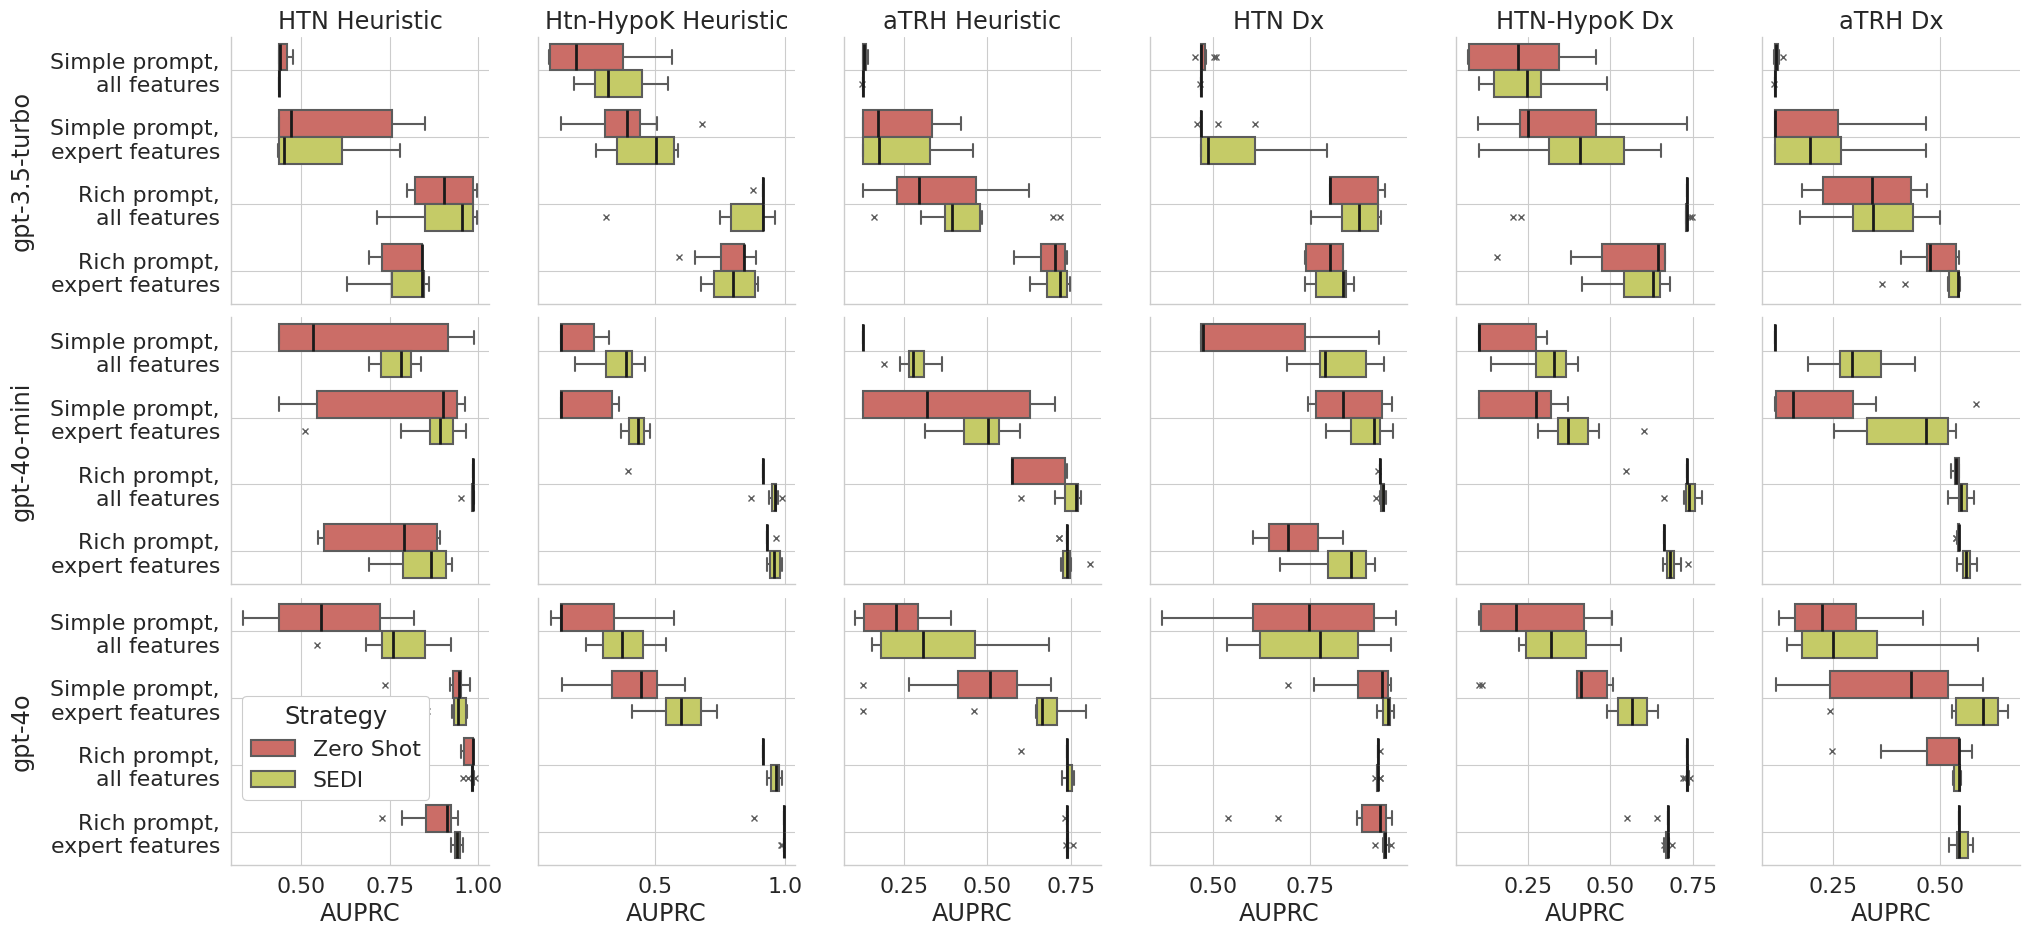

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.8
)
# sns.set_style('whitegrid')
# for target in results_df.target.unique():
for metric in [
    # 'accuracy_score_train',
    # 'accuracy_score_test',
    # 'average_precision_score_train',
    'average_precision_score_test',
    # 'roc_auc_score_train',
    # 'roc_auc_score_test',
    # 'size'
]: 
    data = results_df_melted[
        (results_df_melted['variable']==metric)
        # &
        # (results_df_melted['target']==target)
    ].copy()

    # grouping by iteration and calculating the average across folds
    # display(data)
    data = data.groupby([c for c in data.columns if c not in ['fold', 'value']])['value'].mean().reset_index()
    # display(data)
    
    data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]
    hue_order=['Zero Shot','SEDI']
    
    # data = data[~data['model'].str.contains("iterative")]
    
    metric = metric.replace('average_precision_score_test', 'AUPRC')

    data = data.rename(columns={'value': metric}) #, 'model':'Model'})
    data['Model'] = data['model'].apply(lambda x: x.replace('-iter',''))

    data['Setting'] = data[['icd_only', 'prompt_richness']].apply(
        lambda row: 
        f"{'Rich prompt,\n'  if row.prompt_richness  else 'Simple prompt,\n'}"
        f"{'expert features' if row.icd_only else 'all features'}", 
    axis=1)
    # col.name = 'Setting'
    data['Dx Description'] = data['prompt_richness'].apply(lambda x: 'Detailed' if x else 'Simple')
    data['Feature Set'] = data['icd_only'].apply(lambda x: 'Minimal' if x else 'Full')

    plt_data_args = dict(
        # y='Model', 
        data=data,
        y='Setting',
        order = [
            'Simple prompt,\nall features',
            'Simple prompt,\nexpert features',
            'Rich prompt,\nall features',
            'Rich prompt,\nexpert features',
        ],
        x=metric, 
        # order=[m for m in model_order if m in data['Model'].unique()],
        hue='Strategy',
        hue_order=hue_order,
        palette = palette,

    )
    
    g = sns.catplot(
        row='Model',
        row_order=[m for m in model_order if m in data['Model'].unique()],
        col='target',
        col_order=phenotypes_order,
        aspect=1, 
        height=3,
        margin_titles=True,
        estimator=np.median,
        linewidth=1.5,
        kind='box',
        dodge=True,
        # capsize=.4,
        # err_kws={"color": ".5", "linewidth": 1.5},
        # edgecolor=".5", 
        # errorbar=('ci',95),
        # errwidth=1.5,
        # facecolor='w',
        # errorbar=('pi',95),
        # kind="box", 
        # join=False,
        # dodge=True,
        # boxplot kwards
        notch=False,
        showcaps=True,
        # showfliers=False,
        flierprops={"marker": "x"},
        medianprops={"color": "k", "linewidth": 2},
        sharex='col',
        # **boxplot_kwargs,
        **plt_data_args
    )
    
    # g.map_dataframe(sns.stripplot, dodge=True, **plt_data_args, alpha=.25)
              
    g.set_titles(
        col_template="{col_name}",
        row_template='{row_name}')
    g.set_ylabels('')
    # g.set_xlabels(yaxis.replace(' test',''))

    g.set_xlabels(metric.replace('_', ' ').replace(' test',''))
    # g.set_xlabels(metric.replace('_', ' ').replace(' test','').title())

    plt.subplots_adjust(
        left=0.1,
        right=1,
        bottom=0,
        top=0.92,
        hspace = 0.05
    )
      
    for ax in g.axes.flat:
        ttl = ax.get_title()
        ax.set_title(
            ttl
            .replace('Diagnosis','Dx')
            .replace('Resistant HTN', 'aTRH')
            .replace('Hypokalemia','HypoK')
        )
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        if 'roc' in metric:
            ax.set_xlim(left=0.4)
      
    sns.move_legend(
        g, 
        "upper left", 
        bbox_to_anchor=(0.1, .2),
        # ncols=2,
        frameon=True,
        framealpha=1
    )

    for margin_title in g._margin_titles_texts:
        # margin_title.set_color("red")
        margin_title.set_rotation(90)
        margin_title.set_position((-6.80, margin_title.get_position()[1]))

    plt.savefig(f"{paper_dir}/llm_comparison_boxplot_{metric}.pdf",
               bbox_inches='tight')
    plt.savefig(f"{paper_dir}/llm_comparison_boxplot_{metric}.png")
    plt.show()

In [6]:
data.Model.unique()

array(['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini'], dtype=object)

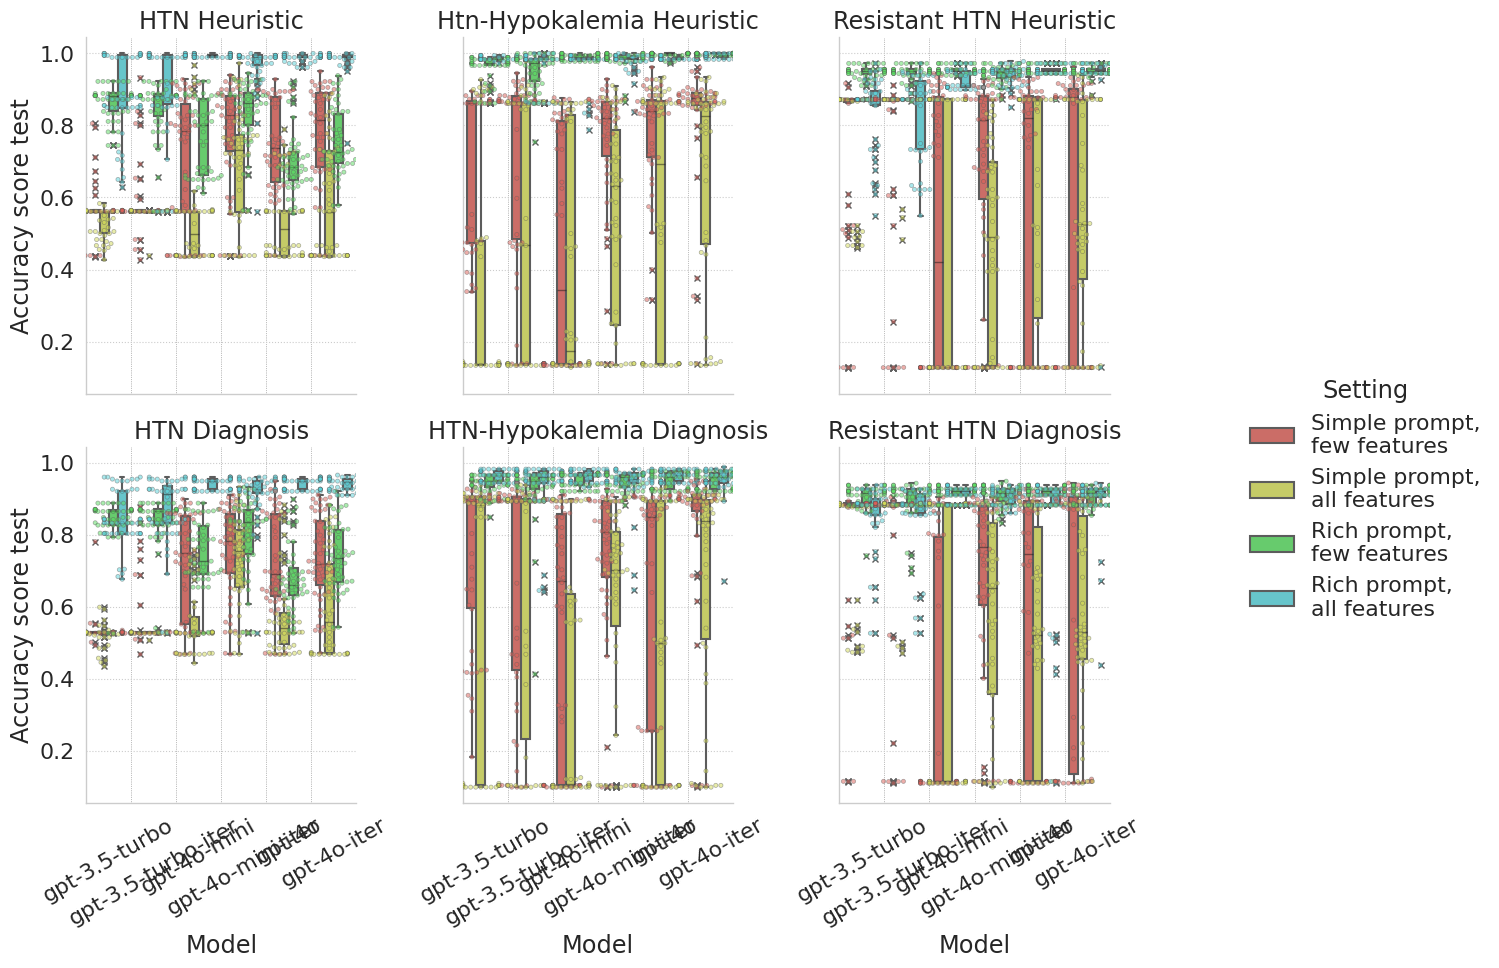

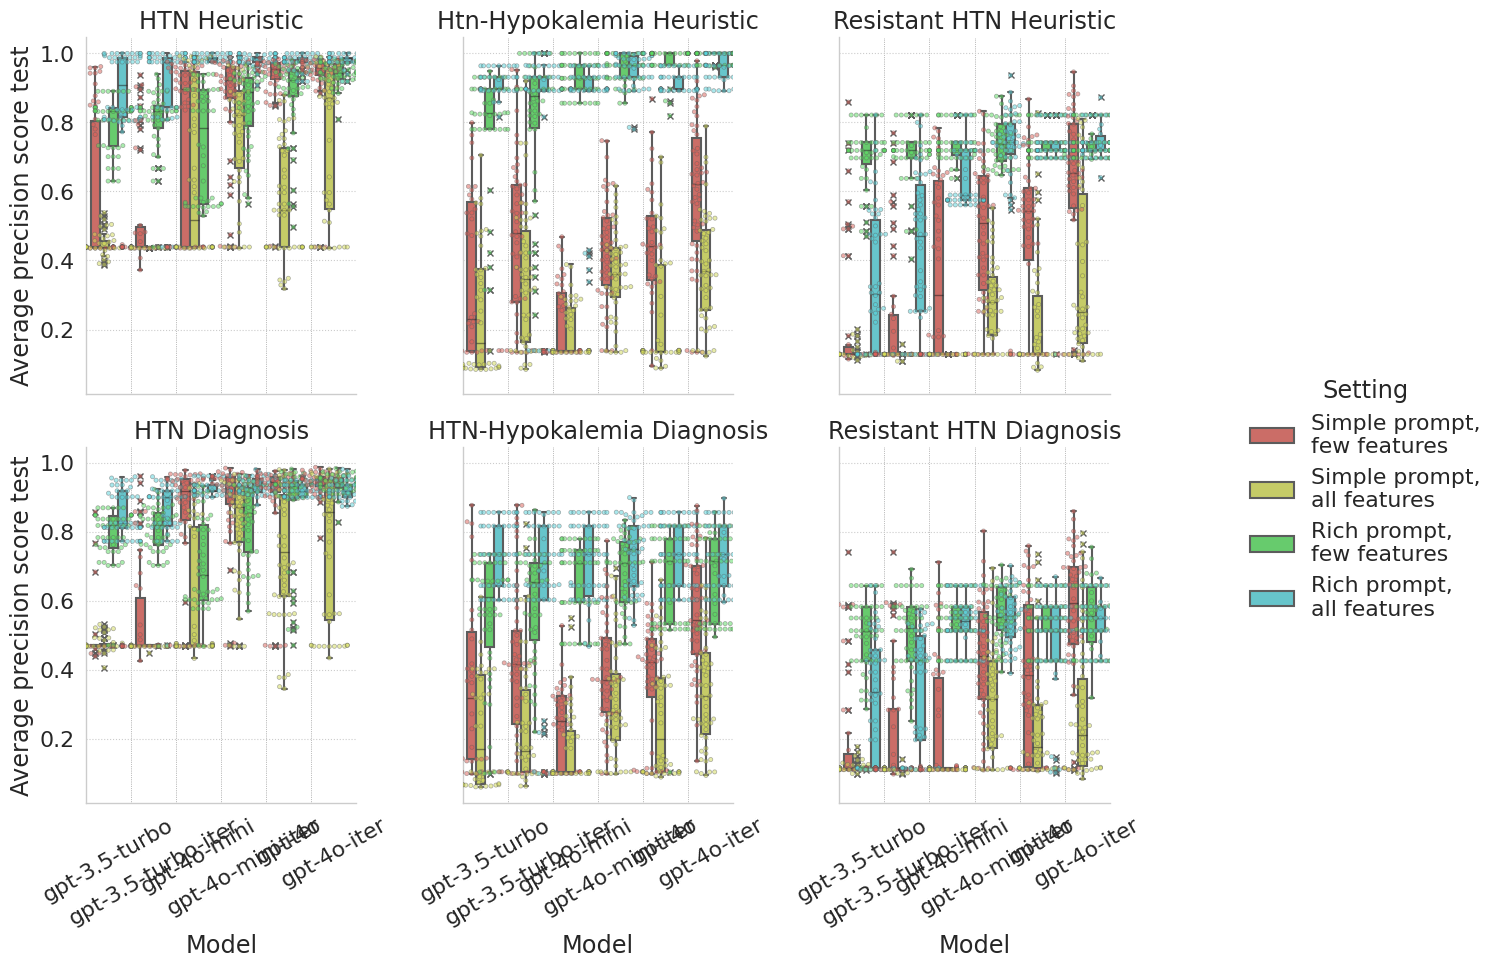

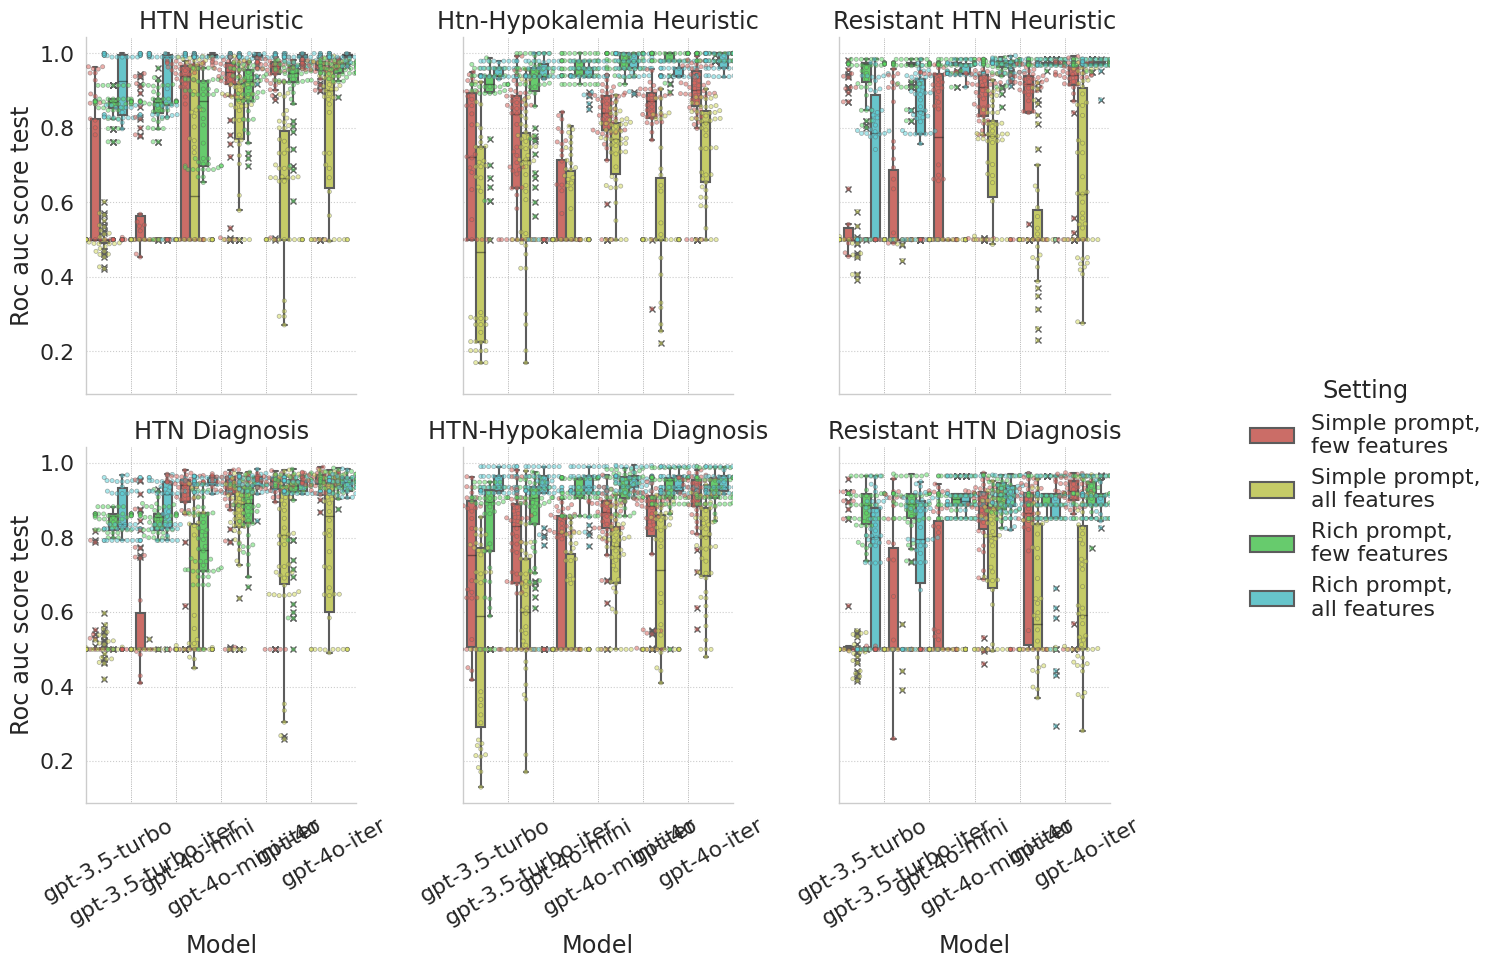

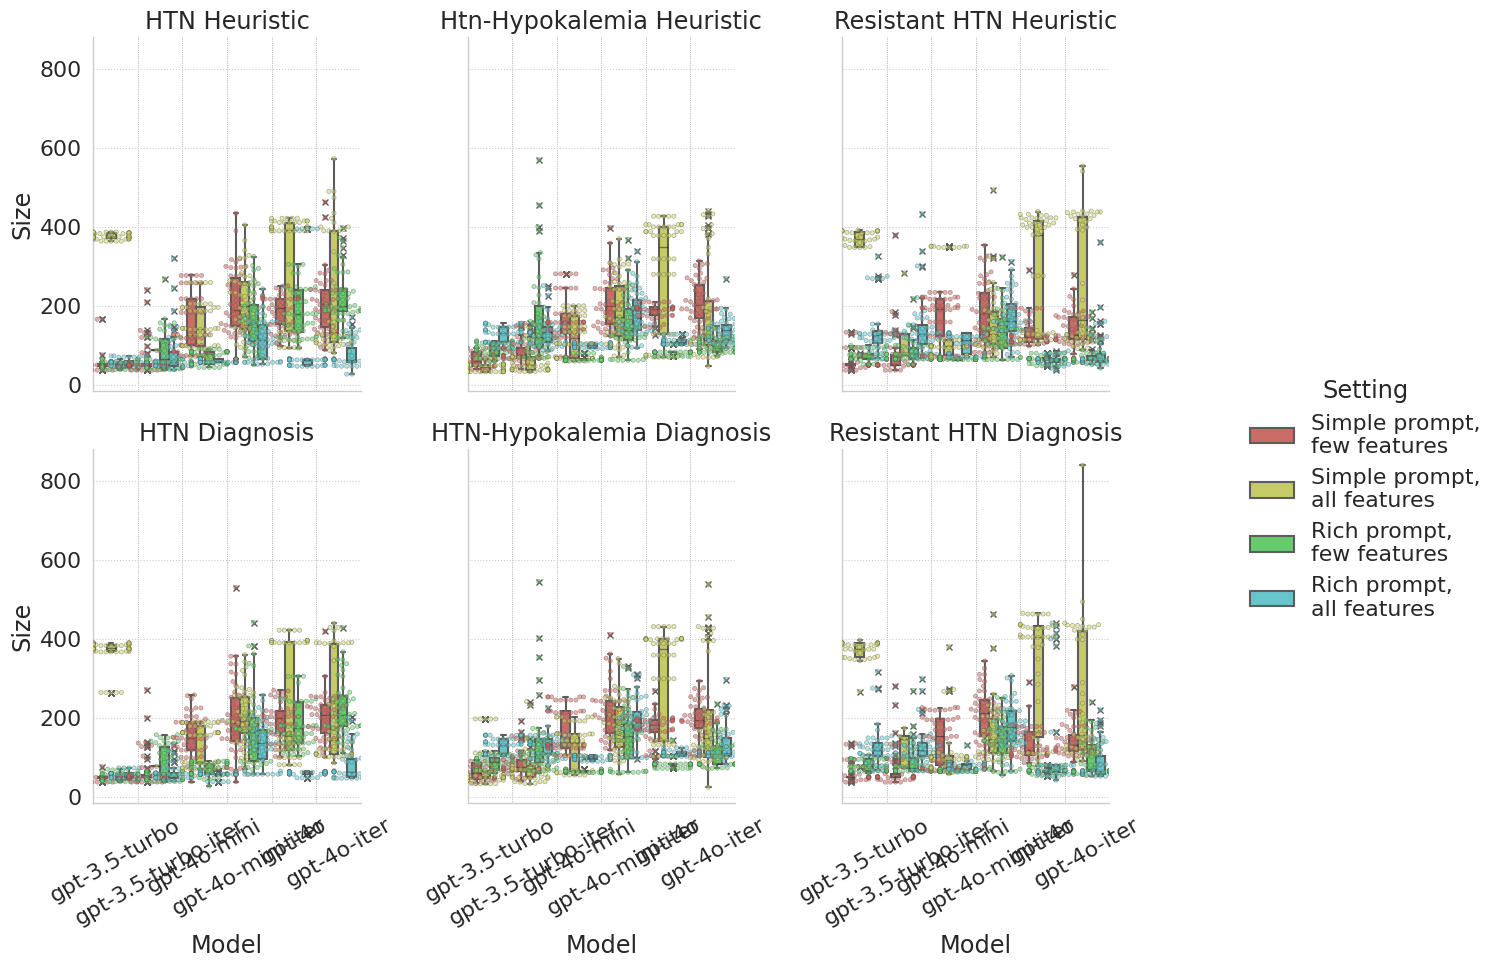

In [7]:
for yaxis in [
    # 'accuracy_score_train',
    'accuracy_score_test',
    # 'average_precision_score_train',
    'average_precision_score_test',
    # 'roc_auc_score_train',
    'roc_auc_score_test',
    'size'
]: 
    data = results_df_melted[results_df_melted['variable']==yaxis]
    
    # data = data[~data['model'].str.contains("iterative")]
    
    yaxis = yaxis.replace('_', ' ').capitalize()

    data = data.rename(columns={'value': yaxis, 'model':'Model'})

    hue= data[['icd_only', 'prompt_richness']].apply(
        lambda row: f"{'Rich prompt,\n' if row.prompt_richness else 'Simple prompt,\n'}{'few features' if row.icd_only else 'all features'}", axis=1)
    hue.name = 'Setting'

    g = sns.catplot(
        data=data,
        x="Model", y=yaxis, order=[m for m in model_order if m in data['Model'].unique()],
        col="target", col_wrap=3, col_order = phenotypes_order,
        hue=hue, hue_order=settings_order,
        aspect=0.8, estimator=np.median,
        palette = palette,
        linewidth=1.5,
        kind="box", **boxplot_kwargs
    )

    [g.refline(x=x, color='gray', lw=0.5, ls=':', zorder=0)
        for x in [0.5, 1.5,2.5,3.5,4.5]]
    
    # hatches must equal the number of hues (3 in this case)
    hatches = ['///', '///', '', '']

    # iterate through each subplot / Facet
    for ax in g.axes.flat:
        # select the correct patches (works only if all results exist)
        patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        n_models = len(data['Model'].unique())

        # print(len(patches), n_models)

        # iterate through the patches for each subplot
        # assert len(patches)==4*n_models, "Inconsistent number of results"

        if len(patches)!=4*n_models:
            continue
        
        # for patch, hatch in zip(patches*n_models, h):
        #     patch.set_hatch(hatch)
            # fc = patch.get_facecolor()
            # patch.set_edgecolor(fc)
            # patch.set_facecolor('none')

    for (title, xaxis) in g._axes_dict.items():
        xaxis.set_title(title)
        # xaxis.set_ylabel(yaxis)
        # xaxis.grid(which='major', axis='y', linewidth=.8)
        xaxis.grid(which='both', axis='both', ls=":", linewidth=.8)

        for tick in xaxis.get_xticklabels():
            tick.set(rotation=30, ha='center', va='top', ma='right')

    g.map_dataframe(sns.swarmplot, y=yaxis, dodge=True, 
                    x="Model", order=[m for m in model_order if m in data['Model'].unique()],
                    # col_order = phenotypes_order,
                    hue=hue, hue_order=settings_order,
                    palette = palette, size=3,
                    linewidth=0.5, alpha=0.5)

    # sns.move_legend(g, "upper center", ncol=4, title=None, frameon=False, bbox_to_anchor=(.5, 1.08), )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.86, 0.625))

    # for lp, hatch in zip(g.legend.get_patches(), hatches):
    #     lp.set_hatch(hatch)
        # fc = lp.get_facecolor()
        # lp.set_edgecolor(fc)
        # lp.set_facecolor('none')
        
    # plt.tight_layout()
    plt.savefig(f"{paper_dir}/llm_comparison_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/llm_comparison_{yaxis}.png")
    plt.show()

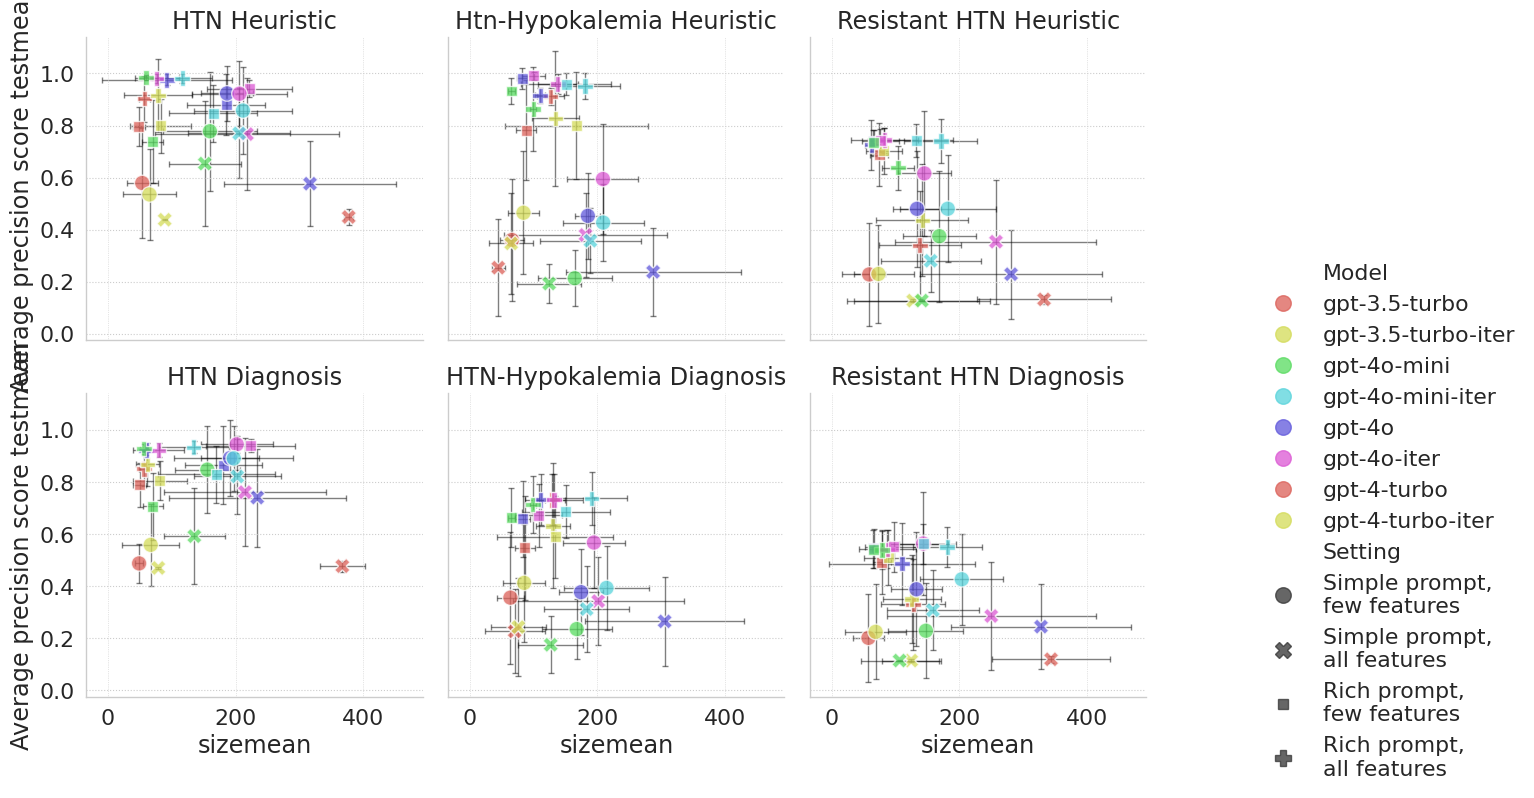

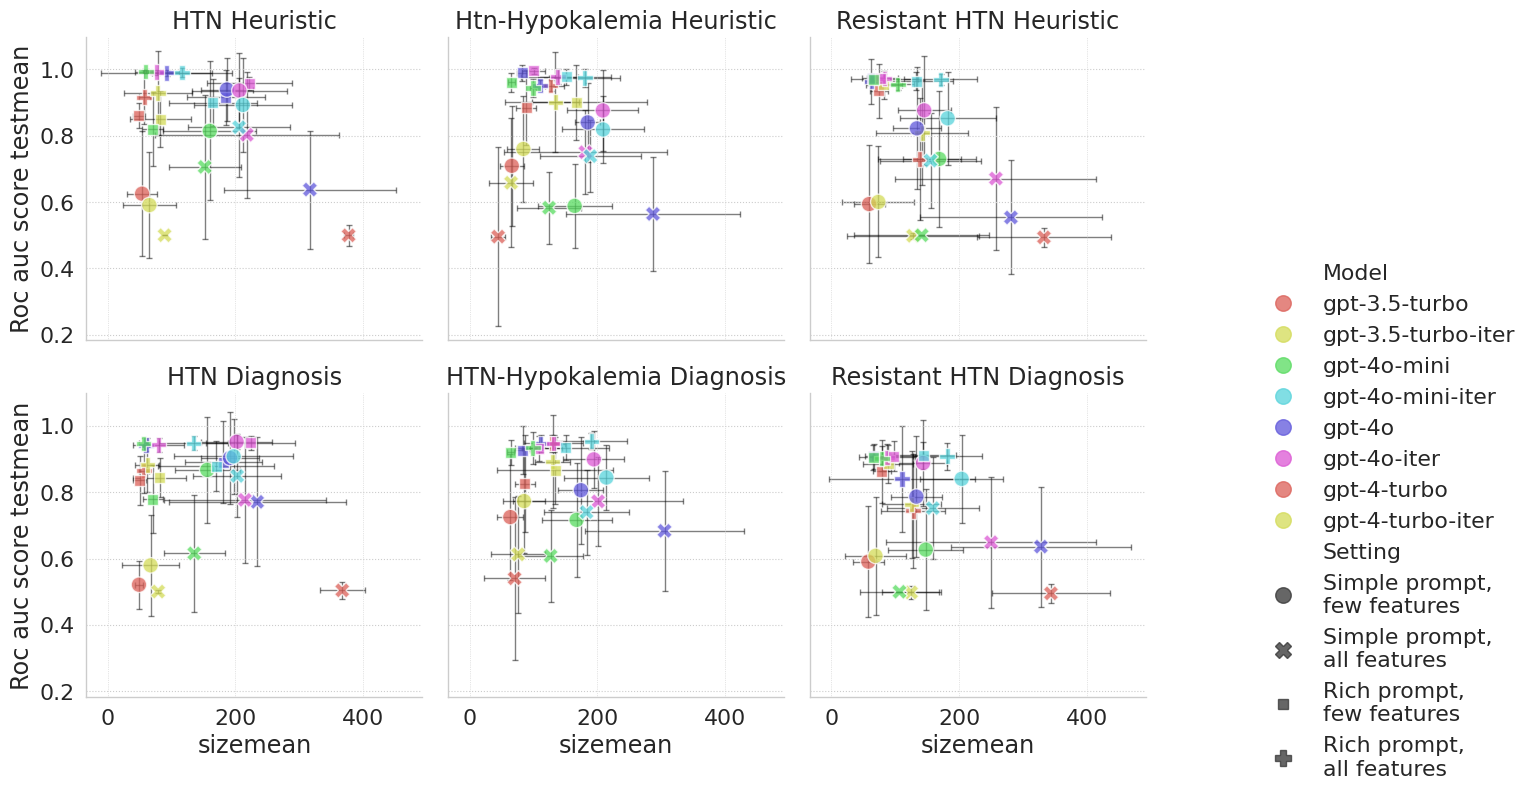

In [8]:
# Copying Fig.3 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"
for yaxis in ['average_precision_score_test', 'roc_auc_score_test']:
    
    data = results_df.rename(columns={yaxis: yaxis.replace('_', ' ').capitalize(), 'model':'Model'})
    yaxis = yaxis.replace('_', ' ').capitalize()
    
    data['Setting'] = data[['icd_only', 'prompt_richness']].apply(
        lambda row: f"{'Rich prompt,\n' if row.prompt_richness else 'Simple prompt,\n'}{'few features' if row.icd_only else 'all features'}", axis=1)

    data = data.groupby(['target', 'Model', 'Setting'])[[yaxis, 'size']].agg(['mean', 'std']).reset_index()
    data.columns = list(map(''.join, data.columns.values))

    g = sns.relplot(
        data=data,
        x="sizemean", y=f"{yaxis}mean", aspect=1, height=4, 
        col="target", col_wrap=3, col_order=phenotypes_order,
        kind="scatter",
        hue='Model', hue_order=model_order,
        palette = palette,
        style ='Setting', style_order=settings_order,
        linewidth=1.0, s=125, alpha=0.75, 
    )

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.set_title(ds)
        plot_ax.grid(which='major', axis='y', linewidth=.8, ls=':')
        plot_ax.grid(which='major', axis='x', linewidth=.5, ls=':')
        
        # for tick in plot_ax.get_xticklabels():
        #     tick.set(rotation=30, ha='center', va='top', ma='right')

    # Create error bars using the std column
    for (ds, plot_ax) in g._axes_dict.items():
        # Get data points for this subplot
        mask = data['target'] == ds
        x_data = data[mask]['sizemean']
        x_std = data[mask]['sizestd']

        y_data = data[mask][f"{yaxis}mean"]
        y_std = data[mask][f"{yaxis}std"]
        
        # Plot error bars for each point
        for i, (x, x_std, y, y_std) in enumerate(zip(x_data, x_std, y_data, y_std)):
            plot_ax.errorbar(
                x=x, 
                y=y, 
                xerr=x_std,
                yerr=y_std,
                fmt='none',  # No marker, just error bars
                color='black',
                capsize=2,
                elinewidth=1,
                capthick=1,
                alpha=0.5,
                zorder=-999
            )

    # g.set(xscale="log")

    sns.move_legend(g, "upper left", bbox_to_anchor=(0.87, 0.675))
    # plt.tight_layout()
    plt.savefig(f"{paper_dir}/llm_pareto_grouped_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/llm_pareto_grouped_{yaxis}.png")
    plt.show()

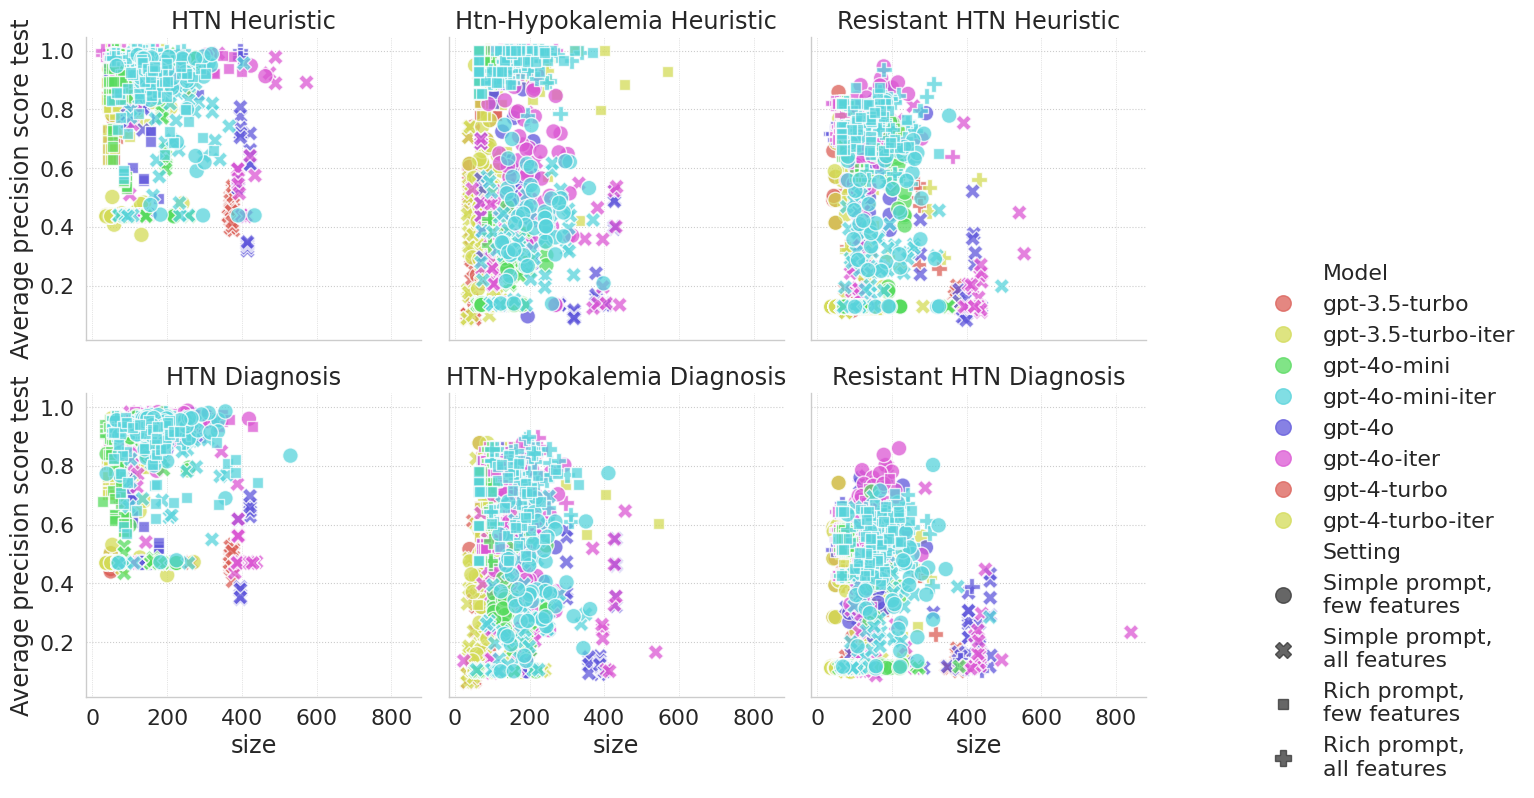

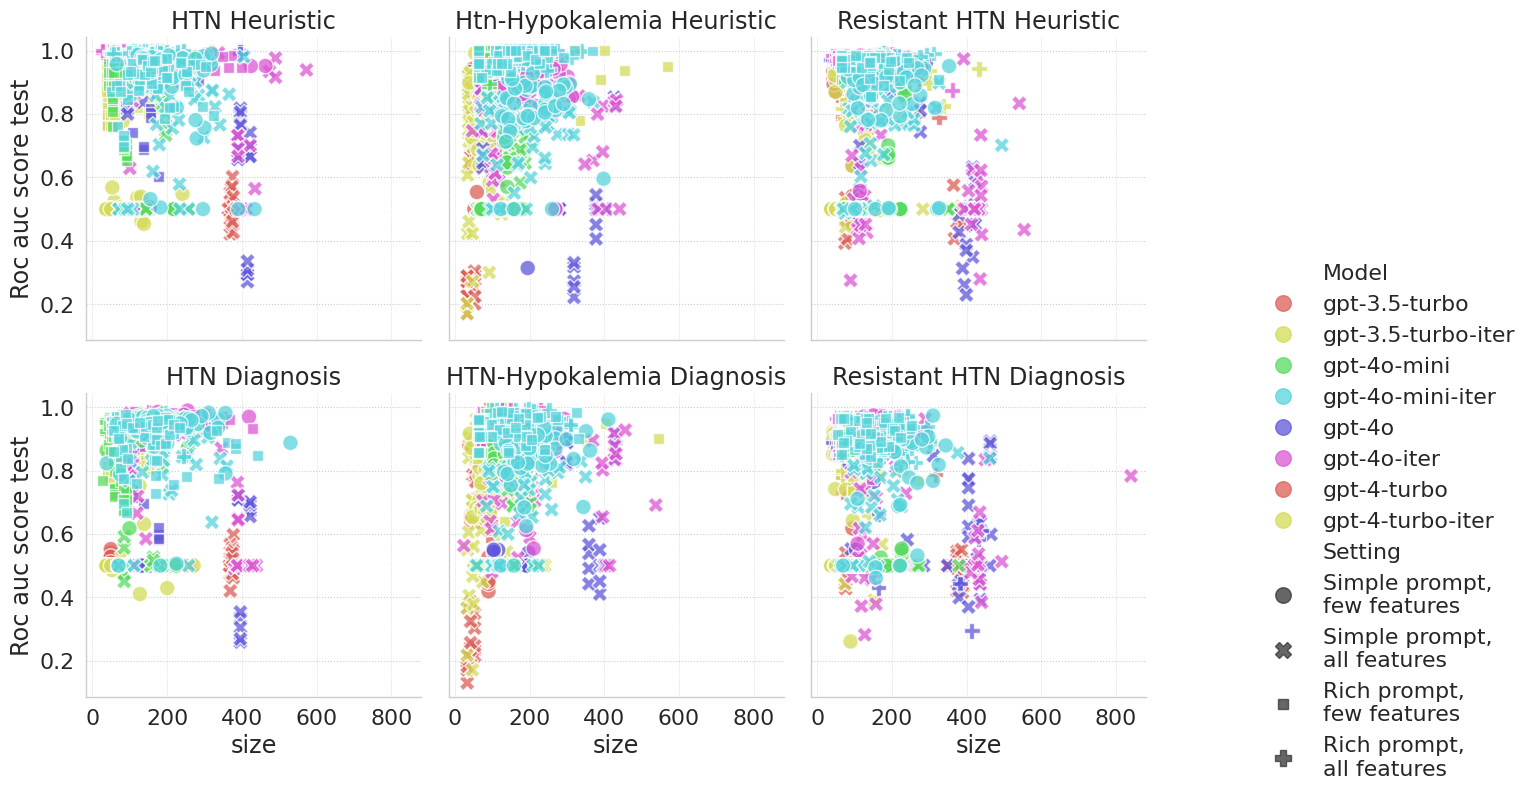

In [9]:
# Copying Fig.3 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"
for yaxis in ['average_precision_score_test', 'roc_auc_score_test']:
    
    data = results_df.rename(columns={yaxis: yaxis.replace('_', ' ').capitalize(), 'model':'Model'})
    yaxis = yaxis.replace('_', ' ').capitalize()
    
    data['Setting'] = data[['icd_only', 'prompt_richness']].apply(
        lambda row: f"{'Rich prompt,\n' if row.prompt_richness else 'Simple prompt,\n'}{'few features' if row.icd_only else 'all features'}", axis=1)

    g = sns.relplot(
        data=data,
        x="size", y=f"{yaxis}", aspect=1, height=4, 
        col="target", col_wrap=3, col_order=phenotypes_order,
        kind="scatter",
        hue='Model', hue_order=model_order,
        palette = palette,
        style ='Setting', style_order=settings_order,
        linewidth=1.0, s=125, alpha=0.75, 
    )

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.set_title(ds)
        plot_ax.grid(which='major', axis='y', linewidth=.8, ls=':')
        plot_ax.grid(which='major', axis='x', linewidth=.5, ls=':')
        
        # for tick in plot_ax.get_xticklabels():
        #     tick.set(rotation=30, ha='center', va='top', ma='right')

    # g.set(xscale="log")

    sns.move_legend(g, "upper left", bbox_to_anchor=(0.87, 0.675))
    # plt.tight_layout()
    plt.savefig(f"{paper_dir}/llm_pareto_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/llm_pareto_{yaxis}.png")
    plt.show()

In [10]:
from sklearn.metrics import (roc_auc_score,
                             roc_curve,
                             precision_recall_curve,
                             auc,
                             )
from scipy import interp
from scipy.stats import sem, t

def parse(pred):
    pred = pred.replace('\n','')
    pred = pred.replace('[','')
    pred = pred.replace(']','')
    pred = list(map(float,pred.split()))
    return pred

def prc_values(y,y_pred_proba):
    precision, recall, prcthresholds = precision_recall_curve(y, y_pred_proba, pos_label=1)
    precision[-1] = np.max(precision[:-1])
    s = np.argsort(recall)
    precision = precision[s]
    recall = recall[s]
    mean_recall = np.linspace(0.0, 1, 21)
    precision = interp(mean_recall, recall, precision)
    return mean_recall, precision

def roc_values(y,y_pred_proba):
    fpr,tpr, rocthresholds = roc_curve(y, y_pred_proba, pos_label=1)
    roc = pd.DataFrame(list(zip(fpr,tpr, rocthresholds)), columns =['fpr','tpr','thresholds']) 
    roc = roc.sort_values(by='fpr')
    tpr = roc['tpr']
    fpr = roc['fpr']
    mean_fpr = np.linspace(0, 1, 21)
    tpr = interp(mean_fpr, fpr, tpr)
    return mean_fpr, tpr

HTN Diagnosis,Htndx,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
 - 1 E 16695
 - 1 E 24284
 - 1 E 24481
 - 1 E 27690
 - 1 E 31658
gpt-3.5-turbo [array([0.86176947, 0.86176947, 0.86176947, 0.86176947, 0.86176947,
       0.86176947, 0.86176947, 0.86176947, 0.86176947, 0.86176947,
       0.86176947, 0.86176947, 0.86176947, 0.86176947, 0.86176947,
       0.86176947, 0.86176947, 0.78

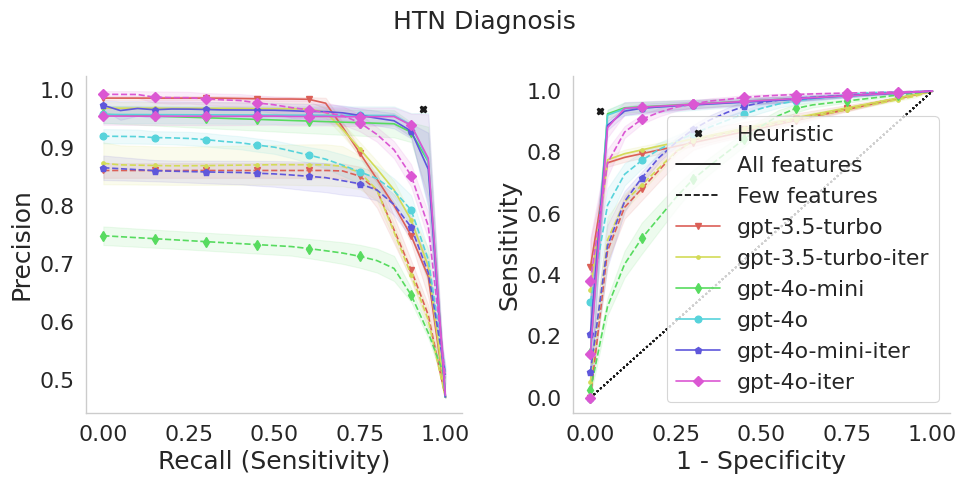

HTN Heuristic,HtnHeuri,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
 - 1 E 16695
 - 1 E 24284
 - 1 E 24481
 - 1 E 27690
 - 1 E 31658
gpt-3.5-turbo [array([0.87310974, 0.87310974, 0.87310974, 0.87310974, 0.87310974,
       0.87310974, 0.87310974, 0.87310974, 0.87310974, 0.87310974,
       0.87310974, 0.87310974, 0.87310974, 0.87310974, 0.87310974,
       0.87310974, 0.8483789 , 0

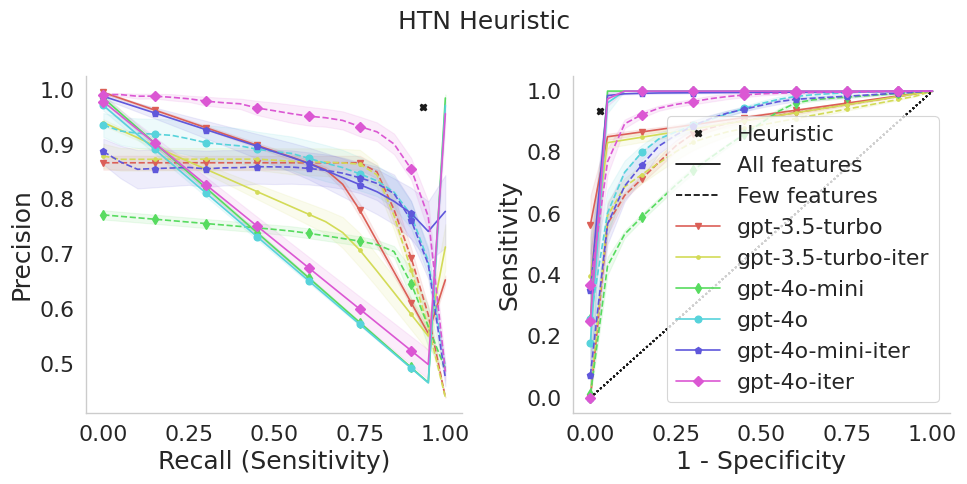

HTN-Hypokalemia Diagnosis,HtnHypoKdx,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
 - 1 E 16695
 - 1 E 24284
 - 1 E 24481
 - 1 E 27690
 - 1 E 31658
gpt-3.5-turbo [array([0.70470375, 0.70470375, 0.70470375, 0.70470375, 0.70470375,
       0.70470375, 0.70470375, 0.70470375, 0.70022861, 0.69314297,
       0.68605734, 0.67002143, 0.64404076, 0.6180601 , 0.59207944,
       0.56609878,

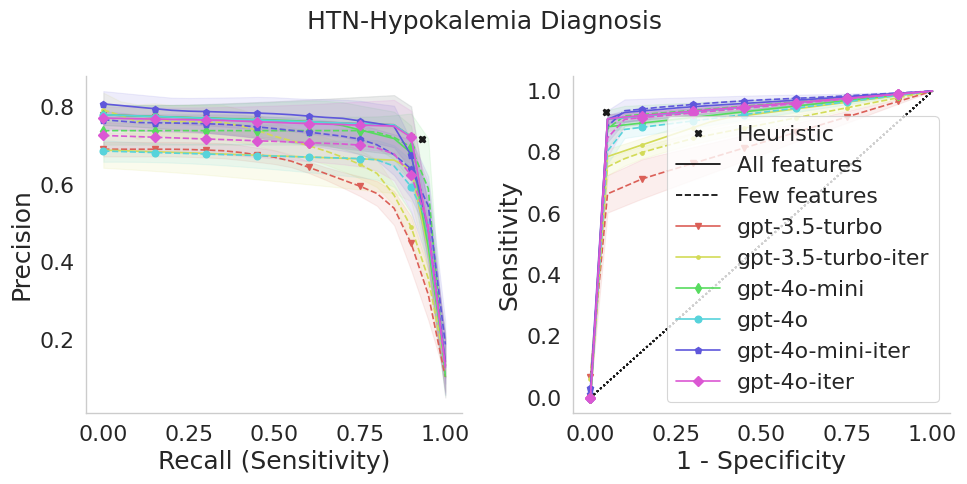

Htn-Hypokalemia Heuristic,HtnHypoKHeuri,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
    There are 103 non-numeric values (out of 181). Set to zero
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
    There are 109 non-numeric values (out of 180). Set to zero
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
    There are 104 non-numeric values (out of 180). Set to zero
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
    There are 109 non-numeric values (out of 179). Set to zero
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
    There are 108 non-numeric values (out of

Resistant HTN Diagnosis,ResHtndx,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
 - 1 E 16695
 - 1 E 24284
 - 1 E 24481
 - 1 E 27690
 - 1 E 31658
gpt-3.5-turbo [array([0.62727982, 0.62727982, 0.62727982, 0.62727982, 0.62727982,
       0.62727982, 0.62727982, 0.62727982, 0.62727982, 0.62727982,
       0.62727982, 0.62727982, 0.62727982, 0.62727982, 0.62235309,
       0.61496298, 0.5

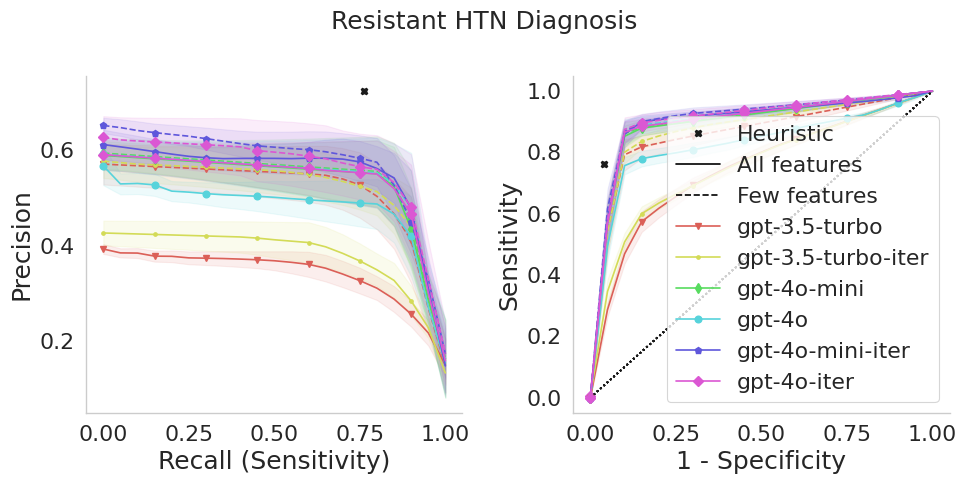

Resistant HTN Heuristic,ResHtnHeuri,(shape (600, 26))
- graphing gpt-3.5-turbo - icd_only True - prompt_richness True - shape (50, 26)
 - 1 A 1318
 - 1 A 6832
 - 1 A 6933
 - 1 A 8233
 - 1 A 14724
 - 1 A 16695
 - 1 A 24284
 - 1 A 24481
 - 1 A 27690
 - 1 A 31658
 - 1 B 1318
 - 1 B 6832
 - 1 B 6933
 - 1 B 8233
 - 1 B 14724
 - 1 B 16695
 - 1 B 24284
 - 1 B 24481
 - 1 B 27690
 - 1 B 31658
 - 1 C 1318
 - 1 C 6832
 - 1 C 6933
 - 1 C 8233
 - 1 C 14724
 - 1 C 16695
 - 1 C 24284
 - 1 C 24481
 - 1 C 27690
 - 1 C 31658
 - 1 D 1318
 - 1 D 6832
 - 1 D 6933
 - 1 D 8233
 - 1 D 14724
 - 1 D 16695
 - 1 D 24284
 - 1 D 24481
 - 1 D 27690
 - 1 D 31658
 - 1 E 1318
 - 1 E 6832
 - 1 E 6933
 - 1 E 8233
 - 1 E 14724
 - 1 E 16695
 - 1 E 24284
 - 1 E 24481
 - 1 E 27690
 - 1 E 31658
gpt-3.5-turbo [array([0.81648148, 0.7922037 , 0.76792593, 0.74364815, 0.71937037,
       0.69509259, 0.67081481, 0.64653704, 0.62225926, 0.59798148,
       0.5737037 , 0.54942593, 0.52514815, 0.50087037, 0.47659259,
       0.45231481, 

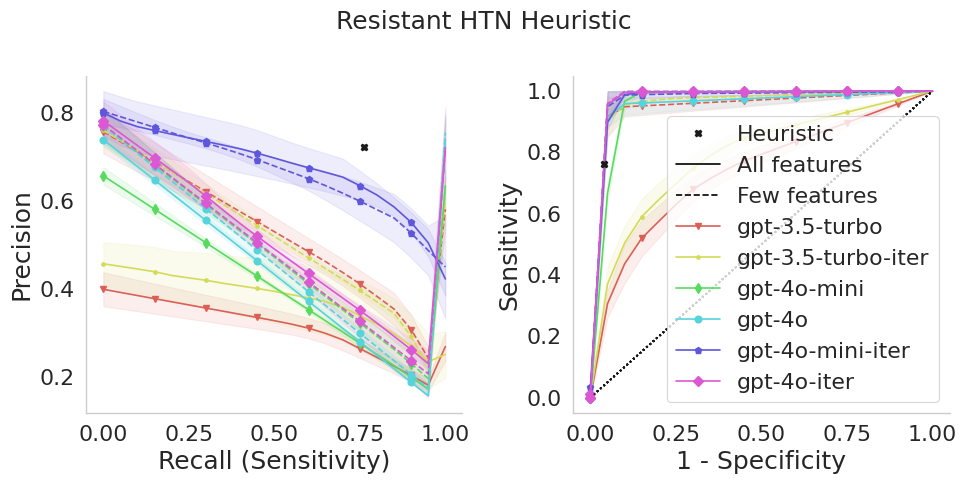

In [11]:
data = results_df
data = data[data['prompt_richness']]
# data = data[~data['icd_only']]

# Calculating rocauc and auprc
spacing, fontsize = 3, 18
for target, perf_t in data.groupby('target'):
    target_new = dnames_to_ugly[target]
    print(target, target_new, f"(shape {perf_t.shape})", sep=",")

    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    i = 1
    for m, model_nice in enumerate([o for o in order if o in perf_t.model.unique()]):
        for icd_only in [True, False]:
            for prompt_richness in [True, False]:
                # model = nice_to_ugly[model_nice]
                perf_t_m = perf_t.loc[ (perf_t.model==model_nice)
                                     & (perf_t.icd_only==icd_only)
                                     & (perf_t.prompt_richness==prompt_richness)] 
                
                if len(perf_t_m) == 0:
                    continue

                print(f'- graphing {model_nice} - icd_only {icd_only} - prompt_richness {prompt_richness} - shape {perf_t_m.shape}')

                mean_run_precisions = []
                mean_run_tprs = []
                if i == 1 and target_new in heuristics.keys():
                    mean_run_precision_h = []
                    mean_run_recall_h = []
                    mean_run_fpr_h = []
                    mean_run_tpr_h = []

                for RunID, perf_t_m_id in perf_t_m.groupby('RunID'):
                    precisions = []
                    tprs = []
                    precisions_h = []
                    recalls_h = []
                    fprs_h = []
                    tprs_h = []

                    for fold, perf_t_m_id_f in perf_t_m_id.groupby('fold'):

                        #True labels
                        df = pd.DataFrame()
                        if fold=="ALL":
                            for f in ['A', 'B', 'C', 'D', 'E']:
                                df = pd.concat([df, pd.read_csv('../data/Dataset' + str(RunID) + '/' +
                                        target_new + '/' + target_new + f +
                                        'Test.csv')])
                        else:
                            df = pd.read_csv('../data/Dataset' + str(RunID) + '/' +
                                        target_new + '/' + target_new + fold +
                                        'Test.csv')
                            
                        y = df[targets_rev[target_new]].values

                        for random_state, perf_t_m_id_f_r in perf_t_m_id_f.groupby('random_state'):
                            print(" -", RunID, fold, random_state)

                            # handle the heuristic
                            if i == 1 and target_new in heuristics.keys():
                                y_heuristic = df[heuristics[target_new]].values

                                # print('y_heuristic:', y_heuristic)

                                precision_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y_heuristic==1)
                                recall_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y==1)

                                # print('precision_h:',precision_h)
                                # print('recall_h:',recall_h)
                                
                                precisions_h.append(precision_h)
                                recalls_h.append(recall_h)

                                fpr_h = np.sum((y==0) & (y_heuristic==1))/np.sum(y==0) 
                                tpr_h = recall_h

                                # print('fpr_h:',fpr_h)
                                # print('tpr_h:',tpr_h)
                            
                                fprs_h.append(fpr_h)
                                tprs_h.append(tpr_h)

                                heuristic=False

                            # print('y:',len(y))

                            #Predicted probabilities
                            assert(len(perf_t_m_id_f_r)==1)

                            # print(perf_t_m_id_f_r['pred_proba'].values[0])
                            # print(type(perf_t_m_id_f_r['pred_proba'].values[0]))
                            # y_pred_proba = eval(perf_t_m_id_f_r['pred_proba'].values[0])
                            y_pred_proba = np.array(perf_t_m_id_f_r['pred_proba'].values[0])
                        
                            mask = np.array([v is None for v in y_pred_proba])
                            if np.sum(mask)> 0:
                                print(f"    There are {np.sum(mask)} non-numeric values (out of {len(mask)}). Set to zero")
                                y_pred_proba[mask] = 0.0

                            # Precision / Recall
                            ####################
                            mean_recall, precision = prc_values(y,y_pred_proba)
                            precisions.append(precision)
                        
                            # ROC
                            #####
                            mean_fpr, tpr = roc_values(y,y_pred_proba)
                            tprs.append(tpr)
                        
                        #mean_run_precisions: The mean of five fold precisions
                        mean_run_precisions.append(np.mean(precisions, axis=0))
                        #mean_run_tprs: The mean of five fold tprs
                        mean_run_tprs.append(np.mean(tprs, axis=0))
                        if i == 1 and target_new in heuristics.keys():
                            mean_run_precision_h.append(np.mean(precisions_h, axis=0))
                            mean_run_recall_h.append(np.mean(recalls_h, axis=0))
                            mean_run_fpr_h.append(np.mean(fprs_h, axis=0))
                            mean_run_tpr_h.append(np.mean(tprs_h, axis=0))

                #mean_precisions: The mean of mean_run_precisions over 50 iterations
                mean_precisions = np.mean(mean_run_precisions, axis=0)

                #mean_tprs: The mean of mean_run_tprs over 50 iterations
                mean_tprs = np.mean(mean_run_tprs, axis=0)
                
        #         plt.figure(target_new, figsize=(10, 6))
                # Precision/Recall plot 
                axs[0].plot(mean_recall, mean_precisions, 
                        alpha=1,
                        c=palette[m],
                        ls='--' if icd_only else '-',
                        label= model_nice + ('\nRich prompt,' if prompt_richness else "\nSimple prompt,") + \
                               ('\few features' if not icd_only else "all features"),
                        marker = marker_choice[model_nice], 
                        markevery=spacing)
            
                # Confidence intervals
                print(model_nice, mean_run_precisions, len(mean_run_precisions))
                std_err = sem(mean_run_precisions, axis=0)
                print(std_err)
                h = std_err * t.ppf(1.95/2, len(mean_run_precisions) - 1)
                precisions_upper = np.minimum(mean_precisions + h, 1)
                precisions_lower = np.maximum(mean_precisions - h, 0)
                axs[0].fill_between(mean_recall, precisions_lower, precisions_upper, 
                                    color=palette[m], alpha=.1, label=r'95% Confidence Interval')
                print(h)

                # ROC plot
                axs[1].plot(mean_fpr, mean_tprs, 
                        alpha=1,
                        c=palette[m],
                        ls='--' if icd_only else '-',
                        label= model_nice + ('\nRich prompt,' if prompt_richness else "\nSimple prompt,") + \
                               ('few features' if not icd_only else "all features"),
                        marker = marker_choice[model_nice], 
                        markevery=spacing)
                axs[1].plot([0,1],[0,1],':k',label=None)

                print(model_nice, mean_run_tprs)
                std_err = sem(mean_run_tprs, axis=0)
                h = std_err * t.ppf(1.95/2, len(mean_run_tprs) - 1)
                tprs_upper = np.minimum(mean_tprs + h, 1)
                tprs_lower = np.maximum(mean_tprs - h, 0)
                axs[1].fill_between(mean_fpr, tprs_lower, tprs_upper, 
                                    color=palette[m], alpha=.1)
                i+=1
                    
    # heuristic performance
#     print('mean_run_precision_h:',mean_run_precision_h)
#     print('mean_run_recall_h:',mean_run_recall_h)
#     print('mean_run_fpr_h:',mean_run_fpr_h)
#     print('mean_run_tpr_h:',mean_run_tpr_h)
    mean_recall_h = np.mean(mean_run_recall_h, axis=0)
    mean_precision_h = np.mean(mean_run_precision_h, axis=0)
    mean_fpr_h = np.mean(mean_run_fpr_h, axis=0)
    mean_tpr_h = np.mean(mean_run_tpr_h, axis=0)

    print(mean_recall_h, mean_precision_h, mean_fpr_h, mean_tpr_h)

    # plot heuristics
    axs[0].plot(mean_recall_h, mean_precision_h, 'Xk', label='Heuristic') 
    h, = axs[1].plot(mean_fpr_h, mean_tpr_h, 'Xk', label='Heuristic') 
    
    plt.suptitle(dnames_to_nice[target_new], fontsize=fontsize)

    axs[0].set_xlabel("Recall (Sensitivity)", fontsize=fontsize)
    axs[0].set_ylabel("Precision", fontsize=fontsize)
    axs[0].grid()
    axs[1].set_xlabel("1 - Specificity", fontsize=fontsize)
    axs[1].set_ylabel("Sensitivity", fontsize=fontsize)
    axs[1].grid()

    # plt.legend(loc='best')

    dummy_all, = plt.plot(0, 0, color='black', linestyle='-')
    dummy_few, = plt.plot(0, 0, color='black', linestyle='--')
    dummy_models = [model_nice for model_nice in [o for o in order if o in data.model.unique()] ]
    dummy_model_colors = [ plt.plot(0,0, alpha=1, c=palette[m], marker = marker_choice[mn])[0]
                           for m, mn in enumerate(dummy_models)]
    plt.legend([h, dummy_all, dummy_few]+dummy_model_colors,['Heuristic', 'All features', 'Few features']+dummy_models)

    plt.tight_layout()
    sns.despine()
    
    # for filetype in ['.svg','.png','.pdf']:
    #     plt.savefig('../paper/' + target_new + '_PRC_ROC'+ filetype, dpi=400)

    plt.savefig(f"{paper_dir}/PRC_ROC_{target_new}.pdf")
    plt.savefig(f"{paper_dir}/PRC_ROC_{target_new}.png")
    plt.show() 